In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('..')  # enable import from src/

In [2]:
from pathlib import Path
import torch

from torcheval.metrics import BinaryF1Score, BinaryAccuracy
from torch.utils.data.sampler import SubsetRandomSampler
from dgl.dataloading import GraphDataLoader

from src.net import InstanceGCN
from src.utils import load_from_wandb
from src.dataset import JobFeasibilityDataset, SatelliteFeasibilityDataset

In [13]:
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
from dgl.nn import HeteroGraphConv, GraphConv, EGATConv, SAGEConv


class ExplainableInstanceGCN(InstanceGCN):
    """Suitable for HeteroGNNExplainer.
    """
    def forward(self, graph, feat, eweight=None):
        with graph.local_scope():
            graph.ndata['x'] = feat
            if eweight is not None:
                graph.edata['A'] = eweight

            return super().forward(graph)


net = ExplainableInstanceGCN(2,)
net = load_from_wandb(net, 'gebp7q0y', 'sat-gnn', 'model_best')

from dgl.nn.pytorch.explain import HeteroGNNExplainer

data = JobFeasibilityDataset('../data/raw/97_9.jl')


feat_importances = list()
for i in range(8000, 9000):
    g, y = data[i]

    explainer = HeteroGNNExplainer(net, 5, )
    feat = g.ndata['x']
    feat['soc'] = torch.zeros((0,0)).to(feat['soc'].unsqueeze(0))

    feat_importance, _ = explainer.explain_graph(data.gs[-1], feat)
    feat_importances.append(feat_importance)

Explain graph:  90%|█████████ | 90/100 [00:00<00:00, 126.41it/s]

(array([5.000e+00, 1.100e+01, 6.200e+01, 1.370e+02, 2.790e+02, 5.270e+02,
        7.710e+02, 9.390e+02, 1.099e+03, 1.014e+03, 8.540e+02, 5.630e+02,
        3.540e+02, 1.740e+02, 9.300e+01, 4.100e+01, 1.900e+01, 3.000e+00,
        2.000e+00, 1.000e+00]),
 array([0.22951497, 0.23474729, 0.23997959, 0.24521191, 0.25044423,
        0.25567654, 0.26090887, 0.26614118, 0.27137351, 0.27660581,
        0.28183812, 0.28707045, 0.29230276, 0.29753506, 0.3027674 ,
        0.3079997 , 0.313232  , 0.31846434, 0.32369664, 0.32892898,
        0.33416128]),
 <BarContainer object of 20 artists>)

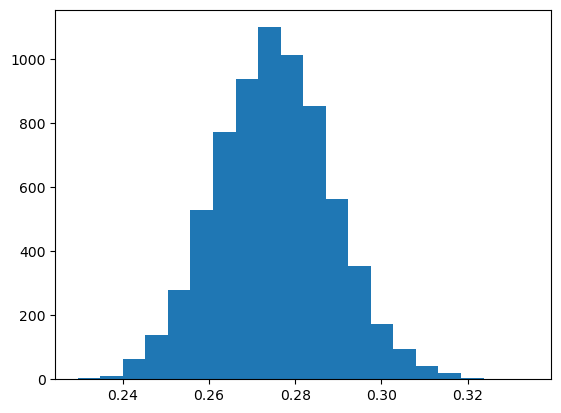

In [63]:
import matplotlib.pyplot as plt

plt.hist(edge_importance[('con', 'c2v', 'var')], bins=20)

In [65]:
new_node_id, sg, feat_importance, edge_importance = explainer.explain_node('var', 1, g, feat)
new_node_id, sg, feat_importance, edge_importance

IndexError: too many indices for tensor of dimension 2

In [30]:
net = InstanceGCN(2,)
net = load_from_wandb(net, 'gebp7q0y', 'sat-gnn', 'model_best')

# only last instance
data = JobFeasibilityDataset('../data/raw/97_9.jl')
sampler = SubsetRandomSampler(torch.arange(8000, len(data)))

dl = GraphDataLoader(data, sampler=sampler, batch_size=2**5)

acc = BinaryAccuracy()
f1 = BinaryF1Score()

net.eval()
with torch.no_grad():
    for X, y in dl:
        y_hat = torch.sigmoid(net(X)).squeeze(1)

        acc.update(y_hat, y)
        f1.update(y_hat, y)
acc.compute(), f1.compute()

(tensor(0.8300), tensor(0.8172))

In [ ]:
net = InstanceGCN(2,)
net = load_from_wandb(net, 'gebp7q0y', 'sat-gnn', 'model_best')

# only last instance
data = JobFeasibilityDataset('../data/raw/97_9.jl')
sampler = SubsetRandomSampler(torch.arange(8000, len(data)))

dl = GraphDataLoader(data, sampler=sampler, batch_size=2**5)

acc = BinaryAccuracy()
f1 = BinaryF1Score()

net.eval()
with torch.no_grad():
    for X, y in dl:
        y_hat = torch.sigmoid(net(X)).squeeze(1)

        acc.update(y_hat, y)
        f1.update(y_hat, y)
acc.compute(), f1.compute()

(tensor(0.8300), tensor(0.8172))

In [34]:
net = InstanceGCN(2,)
net = load_from_wandb(net, '12arvgxb', 'sat-gnn', 'model_best')

# only last instance
data = SatelliteFeasibilityDataset(Path('../data/raw/').glob('97_9*.jl'))
sampler = SubsetRandomSampler(torch.arange(19*1000, len(data)))

dl = GraphDataLoader(data, sampler=sampler, batch_size=2**5)

acc = BinaryAccuracy()
f1 = BinaryF1Score()

net.eval()
with torch.no_grad():
    for X, y in dl:
        y_hat = torch.sigmoid(net(X)).squeeze(1)

        acc.update(y_hat, y)
        f1.update(y_hat, y)
acc.compute(), f1.compute()

(tensor(0.7515), tensor(0.7956))